In [ ]:
# BLOCK A: Imports & basic config

import os
import json
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

import mediapipe as mp  # NEW: for segmentation

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths (adjust root if needed)
DATA_ROOT = Path("./")  # your project root
TRAIN_IMG_DIR = DATA_ROOT / "train"
TEST_IMG_DIR  = DATA_ROOT / "test"

TRAIN_ANN_PATH = TRAIN_IMG_DIR / "_annotations.coco.json"
TEST_ANN_PATH  = TEST_IMG_DIR / "_annotations.coco.json"

# Keypoint / image settings
NUM_KEYPOINTS = 26          # from your COCO categories (FP01..FP26) :contentReference[oaicite:0]{index=0}
KEYPOINT_DIM  = 2           # x, y only (we'll ignore visibility v for regression)
TARGET_SIZE   = 512         # output image size (512 x 512)

BATCH_SIZE = 16
NUM_WORKERS = 4


device(type='cuda')

In [4]:


def load_coco_annotations(json_path):
    """
    Loads COCO annotations and returns:
    - images dict mapping id -> filename, height, width
    - annotations list for each object
    """
    with open(json_path, 'r') as f:
        coco = json.load(f)

    images = {img['id']: img for img in coco['images']}
    annotations = coco['annotations']
    return images, annotations

train_json = r"D:\\Work\\Projects\\Facepoint Recognizer\\Face-Orientation-Detector\\data\\train\\_annotations.coco.json"
test_json  = r"D:\\Work\\Projects\\Facepoint Recognizer\\Face-Orientation-Detector\\data\\test\\_annotations.coco.json"

train_images, train_ann = load_coco_annotations(train_json)
test_images,  test_ann  = load_coco_annotations(test_json)

len(train_ann), len(test_ann)


(515, 82)

In [5]:
# CELL 3 — DATASET CLASS

class KeypointDataset(Dataset):
    def __init__(self, img_root, images_dict, annotations, transform=None):
        self.img_root = img_root
        self.images_dict = images_dict
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        img_info = self.images_dict[anno["image_id"]]
        filename = img_info["file_name"]

        img_path = os.path.join(self.img_root, filename)
        img = Image.open(img_path).convert("RGB")

        w, h = img_info["width"], img_info["height"]

        # Extract keypoints
        kp = np.array(anno["keypoints"]).reshape(-1, 3)[:, :2]  # drop visibility
        kp[:, 0] /= w  # normalize x
        kp[:, 1] /= h  # normalize y

        kp = kp.flatten().astype(np.float32)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(kp)


In [10]:
# CELL 4 — TRANSFORMS & DATALOADERS

input_size = 256

transform_train = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_ds = KeypointDataset(r"D:\\Work\\Projects\\Facepoint Recognizer\\Face-Orientation-Detector\\data\\train", train_images, train_ann, transform_train)
test_ds  = KeypointDataset(r"D:\\Work\\Projects\\Facepoint Recognizer\\Face-Orientation-Detector\\data\\test",  test_images,  test_ann,  transform_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

len(train_ds), len(test_ds)


(515, 82)

In [11]:
# CELL 5 — MODEL: RESNET18 REGRESSION HEAD

class KeypointModel(nn.Module):
    def __init__(self, num_keypoints=26):
        super().__init__()
        self.num_outputs = num_keypoints * 2  # x,y only

        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features
        
        # Replace final layer
        self.backbone.fc = nn.Linear(in_features, self.num_outputs)

    def forward(self, x):
        return self.backbone(x)


model = KeypointModel(num_keypoints=26).to(device)
model


KeypointModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [12]:
# CELL 6 — LOSS, OPTIMIZER, SCHEDULER

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [13]:
# CELL 7 — TRAINING & VALIDATION LOOP WITH CHECKPOINTS

num_epochs = 30
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    
    # ---------- TRAIN ----------
    model.train()
    running_loss = 0.0

    for imgs, kps in tqdm(train_loader, desc="Training"):
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    val_running = 0.0

    with torch.no_grad():
        for imgs, kps in tqdm(test_loader, desc="Validation"):
            imgs = imgs.to(device)
            kps = kps.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, kps)
            val_running += loss.item()

    val_loss = val_running / len(test_loader)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("✔ Saved Best Model")

    # Always save last model
    torch.save(model.state_dict(), "last_model.pth")

    scheduler.step()



Epoch 1/30


Validation: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Train Loss: 0.071767 | Val Loss: 0.025882
✔ Saved Best Model

Epoch 2/30


Validation: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Train Loss: 0.005927 | Val Loss: 0.004911
✔ Saved Best Model

Epoch 3/30


Validation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Train Loss: 0.003482 | Val Loss: 0.002139
✔ Saved Best Model

Epoch 4/30


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


Train Loss: 0.002995 | Val Loss: 0.002258

Epoch 5/30


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Train Loss: 0.002508 | Val Loss: 0.001810
✔ Saved Best Model

Epoch 6/30


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Train Loss: 0.002799 | Val Loss: 0.003610

Epoch 7/30


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Train Loss: 0.004267 | Val Loss: 0.001447
✔ Saved Best Model

Epoch 8/30


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Train Loss: 0.001663 | Val Loss: 0.001266
✔ Saved Best Model

Epoch 9/30


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Train Loss: 0.002088 | Val Loss: 0.001693

Epoch 10/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


Train Loss: 0.002363 | Val Loss: 0.001901

Epoch 11/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Train Loss: 0.001508 | Val Loss: 0.000714
✔ Saved Best Model

Epoch 12/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Train Loss: 0.001022 | Val Loss: 0.000559
✔ Saved Best Model

Epoch 13/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Train Loss: 0.000840 | Val Loss: 0.000470
✔ Saved Best Model

Epoch 14/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Train Loss: 0.001033 | Val Loss: 0.000524

Epoch 15/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Train Loss: 0.000912 | Val Loss: 0.000635

Epoch 16/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Train Loss: 0.000967 | Val Loss: 0.000462
✔ Saved Best Model

Epoch 17/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Train Loss: 0.001071 | Val Loss: 0.000496

Epoch 18/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Train Loss: 0.000877 | Val Loss: 0.000477

Epoch 19/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Train Loss: 0.000831 | Val Loss: 0.000483

Epoch 20/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Train Loss: 0.001067 | Val Loss: 0.000538

Epoch 21/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Train Loss: 0.000827 | Val Loss: 0.000473

Epoch 22/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Train Loss: 0.000816 | Val Loss: 0.000496

Epoch 23/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Train Loss: 0.000788 | Val Loss: 0.000487

Epoch 24/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Train Loss: 0.000812 | Val Loss: 0.000483

Epoch 25/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Train Loss: 0.000778 | Val Loss: 0.000418
✔ Saved Best Model

Epoch 26/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Train Loss: 0.000666 | Val Loss: 0.000455

Epoch 27/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


Train Loss: 0.000724 | Val Loss: 0.000451

Epoch 28/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Train Loss: 0.000906 | Val Loss: 0.000418

Epoch 29/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Train Loss: 0.000850 | Val Loss: 0.000438

Epoch 30/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

Train Loss: 0.000601 | Val Loss: 0.000430


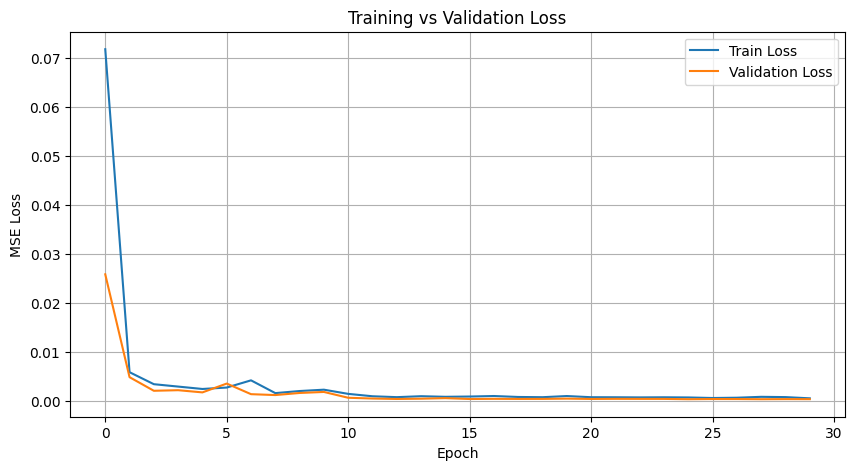

In [14]:
# CELL 8 — PLOT LOSS CURVES

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# CELL 9 — METRICS (MSE, MAE, NME)

def compute_nme(preds, gts, img_w, img_h):
    """
    Normalized Mean Error using image diagonal:
    nme = mean(dist(pred_i, gt_i)) / sqrt(w^2 + h^2)
    preds, gts shape: (batch, 26, 2)
    """
    diag = math.sqrt(img_w**2 + img_h**2)
    dists = np.linalg.norm(preds - gts, axis=2)  # (batch, 26)
    return np.mean(dists) / diag


model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

all_preds = []
all_gts = []

total_mse = 0
total_mae = 0
n_samples = 0

with torch.no_grad():
    for imgs, kps in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        kps = kps.cpu().numpy().reshape(-1, 26, 2)

        outputs = model(imgs).cpu().numpy().reshape(-1, 26, 2)

        # Accumulate for metrics
        mse = np.mean((outputs - kps) ** 2)
        mae = np.mean(np.abs(outputs - kps))
        
        total_mse += mse * len(imgs)
        total_mae += mae * len(imgs)
        n_samples += len(imgs)

        all_preds.append(outputs)
        all_gts.append(kps)

# Final aggregated metrics
final_mse = total_mse / n_samples
final_mae = total_mae / n_samples

# Compute NME assuming normalized coords → use diagonal of 1x1 image = sqrt(2)
# (But better to multiply by original dims; here we use 1.0 normalization)
final_nme = compute_nme(
    preds=np.vstack(all_preds),
    gts=np.vstack(all_gts),
    img_w=1.0,
    img_h=1.0
)

print("\n===== METRICS =====")
print(f"MSE: {final_mse:.6f}")
print(f"MAE: {final_mae:.6f}")
print(f"NME: {final_nme:.6f}")


C:\Users\Aditya_Mishra\AppData\Local\Temp\ipykernel_20436\494907949.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", m


===== METRICS =====
MSE: 0.000447
MAE: 0.015428
NME: 0.017144


In [16]:
# CELL 10 — VISUALIZATION UTILITIES

def draw_keypoints(image_pil, keypoints, color=(0, 0, 255), radius=3):
    """
    image_pil: PIL image
    keypoints: numpy array shape (26, 2) with pixel coordinates
    """
    img = np.array(image_pil).copy()
    for (x, y) in keypoints:
        cv2.circle(img, (int(x), int(y)), radius, color, -1)
    return img


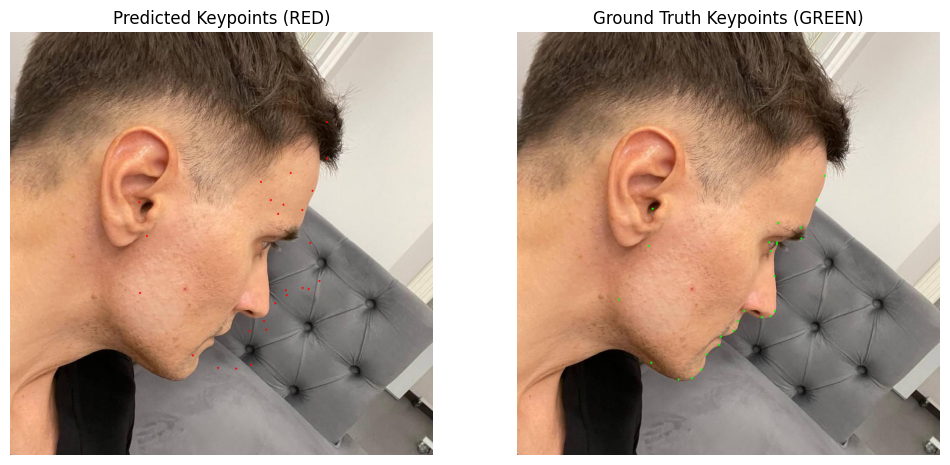

In [18]:
# CELL 11 — VISUALIZE PREDICTED VS GT KEYPOINTS

def visualize_random_prediction():
    idx = np.random.randint(0, len(test_ds))
    img_tensor, kp_norm = test_ds[idx]

    # Load original image for drawing
    img_info = test_images[test_ds.annotations[idx]["image_id"]]
    img_path = os.path.join(r"D:\\Work\\Projects\\Facepoint Recognizer\\Face-Orientation-Detector\\data\\test", img_info["file_name"])
    img_pil = Image.open(img_path).convert("RGB")
    
    W, H = img_info["width"], img_info["height"]

    # Run model prediction
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0).to(device)).cpu().numpy().reshape(26, 2)

    # Denormalize predictions
    pred[:, 0] *= W
    pred[:, 1] *= H

    # Ground truth (denormalize)
    gt = kp_norm.numpy().reshape(26, 2).copy()
    gt[:, 0] *= W
    gt[:, 1] *= H

    # Draw
    img_pred = draw_keypoints(img_pil, pred, color=(255, 0, 0))
    img_gt   = draw_keypoints(img_pil, gt,   color=(0, 255, 0))

    # Show side-by-side
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Predicted Keypoints (RED)")
    plt.imshow(img_pred)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Ground Truth Keypoints (GREEN)")
    plt.imshow(img_gt)
    plt.axis("off")

    plt.show()


# Run visualization once
visualize_random_prediction()


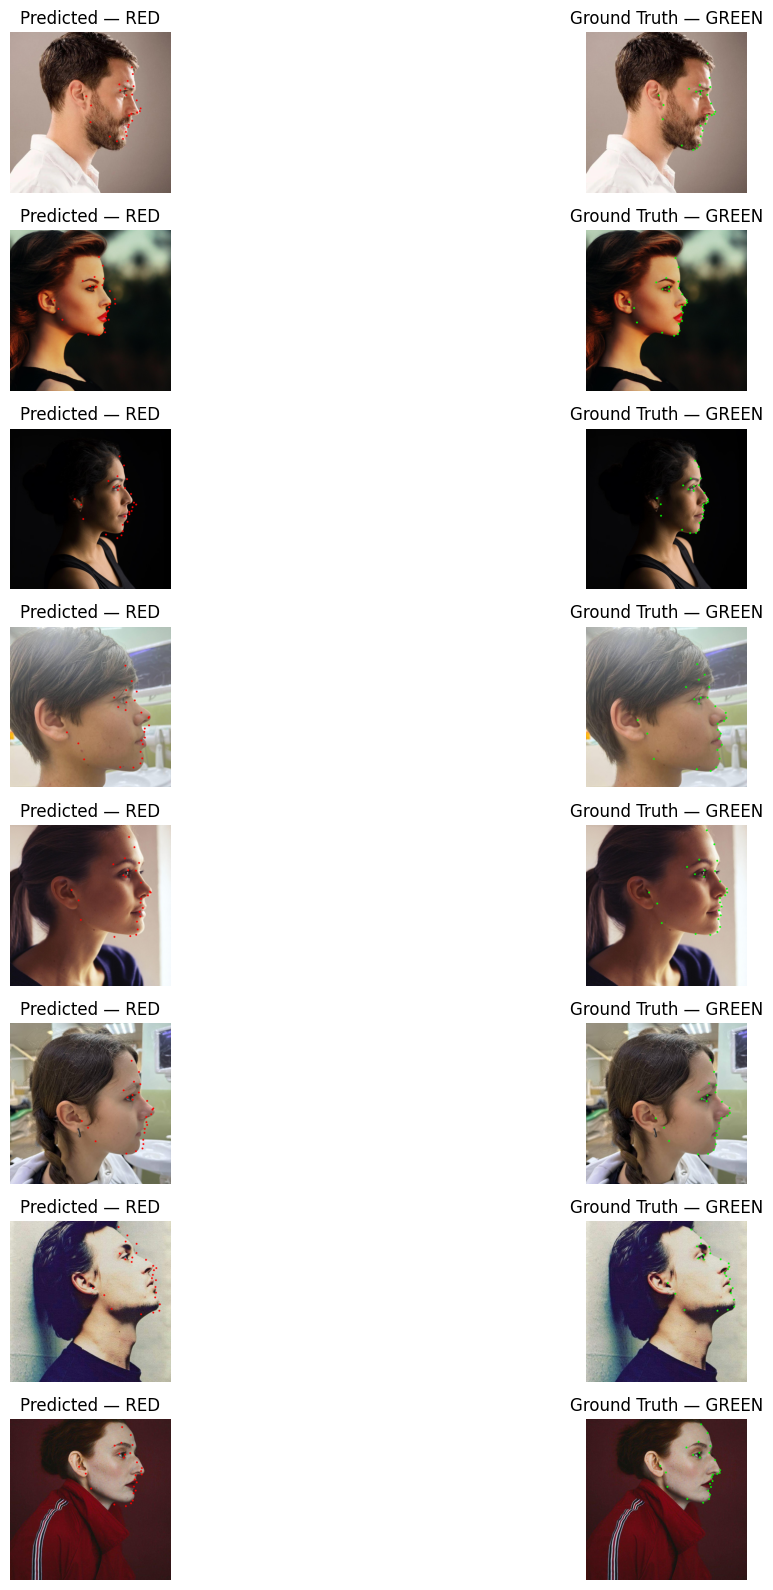

In [19]:
# CELL 12 — MULTIPLE VISUALIZATIONS WITH THICKER DOTS

def draw_keypoints_thick(image_pil, keypoints, color=(0, 0, 255), radius=6):
    """
    Draw thicker and more visible points.
    """
    img = np.array(image_pil).copy()
    for (x, y) in keypoints:
        cv2.circle(img, (int(x), int(y)), radius, color, -1, lineType=cv2.LINE_AA)
    return img


def visualize_batch_predictions(batch_size=8):
    model.eval()
    indices = np.random.choice(len(test_ds), batch_size, replace=False)

    plt.figure(figsize=(16, 2 * batch_size))

    for i, idx in enumerate(indices):
        img_tensor, kp_norm = test_ds[idx]

        # Load high-res original
        img_info = test_images[test_ds.annotations[idx]["image_id"]]
        img_path = os.path.join(r"D:\\Work\\Projects\\Facepoint Recognizer\\Face-Orientation-Detector\\data\\test", img_info["file_name"])
        img_pil = Image.open(img_path).convert("RGB")

        W, H = img_info["width"], img_info["height"]

        # Predict
        with torch.no_grad():
            pred = model(img_tensor.unsqueeze(0).to(device)).cpu().numpy().reshape(26, 2)

        # Denormalize
        pred[:, 0] *= W
        pred[:, 1] *= H

        gt = kp_norm.numpy().reshape(26, 2).copy()
        gt[:, 0] *= W
        gt[:, 1] *= H

        # Draw both
        img_pred = draw_keypoints_thick(img_pil, pred, color=(255, 0, 0), radius=7)
        img_gt   = draw_keypoints_thick(img_pil, gt,   color=(0, 255, 0), radius=7)

        # Show images
        plt.subplot(batch_size, 2, 2 * i + 1)
        plt.title(f"Predicted — RED")
        plt.imshow(img_pred)
        plt.axis("off")

        plt.subplot(batch_size, 2, 2 * i + 2)
        plt.title(f"Ground Truth — GREEN")
        plt.imshow(img_gt)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# RUN BATCH VISUALIZATION
visualize_batch_predictions(batch_size=8)
